<a href="https://colab.research.google.com/github/VKSi/2021_03_GB_NLP/blob/main/HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 8. Рекуррентные нейронные сети RNN LSTM GRU

Материалы
У вас лекционный ноутбук в архиве он с картинками и презентация тоже есть в архиве так же есть два дополнительных ноутбука

rnn.ipynb там только до момента энкодера декодера, мы это чуть позже разбирать будем

text_classification_rnn.ipynb разобрать полностью это задача классификации тут с одной стороны ничего нового, но полезно посмотреть

Задание
На вебинаре мы говорили что долгое время CNN и RNN архитектуры были конурируещими выяснить какая архитектура больше подходит для задачи сантимент анализа на данных с вебинара
1. построить свёрточные архитектуры
2. построить различные архитектуры с RNN
3. попробовать использовать совместно CNN и RNN
4. сдлать выводы что получилось лучше

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/NLP/Lesson8/'

In [ ]:
!pip install stop-words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32917 sha256=e7f745aa97bb4e5d2271efa5ca72021c9d06dadb1809215bfd8a69e6457f4437
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 8.2MB 26.4MB/s 


## Загрузка и предобработка из лекции

In [ ]:
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

df_train = pd.read_csv(PATH+"data/train.csv")
df_test = pd.read_csv(PATH+"data/test.csv")
df_val = pd.read_csv(PATH+"data/val.csv")

In [ ]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [ ]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [ ]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking, Bidirectional, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  

In [ ]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [ ]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [ ]:
y_train = df_train['class'].values
y_val = df_val['class'].values

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def my_plot_graphs(history):
  plt.figure(figsize=(16,8))
  plt.subplot(1,2,1)
  plot_graphs(history, 'accuracy')
  plt.ylim(None,1)
  plt.subplot(1,2,2)
  plot_graphs(history, 'loss')
  plt.ylim(0,None)

## RNN

Чтобы не повторяться (DRY) выделим общую часть в отдельную процедуру

In [ ]:
def my_rnn(main_rnn_layer):
  model = Sequential()
  model.add(
      Embedding(input_dim=word_count,
                input_length=training_length,
                output_dim=30,
                trainable=True,
                mask_zero=True))
  model.add(Masking(mask_value=0.0))

  model.add(main_rnn_layer)
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(
      optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  early_stopping=EarlyStopping(monitor='val_loss')  

  history = model.fit(X_train, y_train,
                      batch_size=512,
                      epochs=10,
                      verbose=1,
                      validation_split=0.1,
                      callbacks=[early_stopping])
  score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
  print('\n')
  print(f'Test score: { score[0]: .3f}' )
  print(f'Test accuracy: {score[1]: .3f}')
  
  return model, history

### Простая RNN (из лекции)

In [ ]:
model_rnn, history_rnn = my_rnn(SimpleRNN(64))

Epoch 1/10
319/319 [==============================] - 35s 107ms/step - loss: 0.6163 - accuracy: 0.6355 - val_loss: 0.4910 - val_accuracy: 0.7556
Epoch 2/10
45/45 [==============================] - 0s 5ms/step - loss: 0.5686 - accuracy: 0.7373


Test score:  0.569
Test accuracy:  0.737


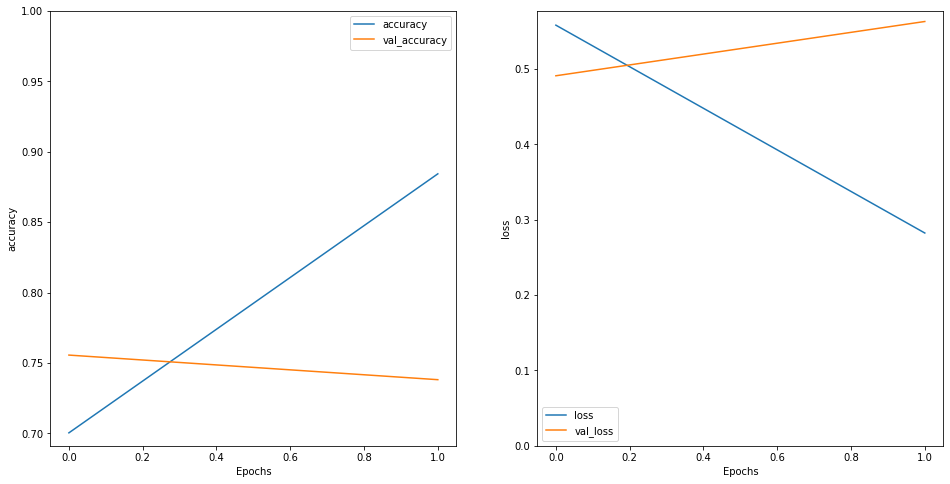

In [ ]:
my_plot_graphs(history_rnn)

### LSTM (из лекции)

In [ ]:
model_lstm, history_lstm = my_rnn(LSTM(64, recurrent_dropout=0.2))

Epoch 1/10
319/319 [==============================] - 58s 176ms/step - loss: 0.6125 - accuracy: 0.6499 - val_loss: 0.4905 - val_accuracy: 0.7552
Epoch 2/10
45/45 [==============================] - 0s 10ms/step - loss: 0.6088 - accuracy: 0.7317


Test score:  0.609
Test accuracy:  0.732


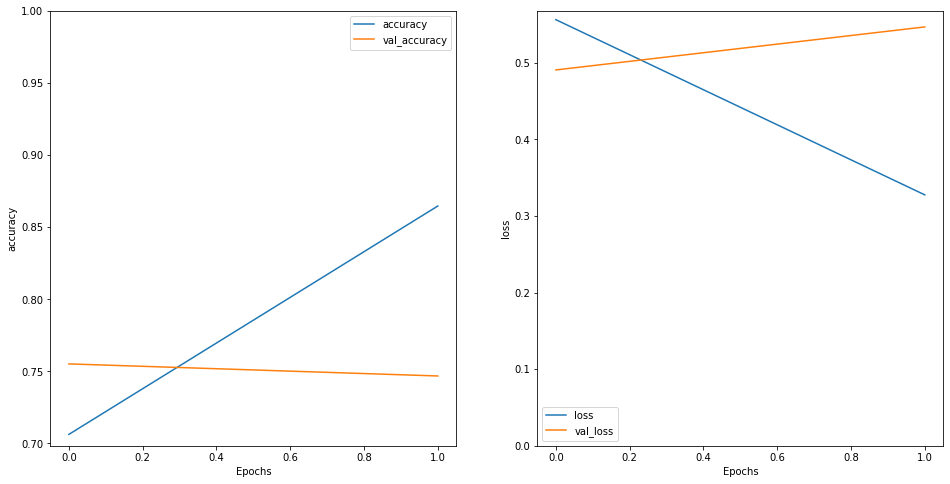

In [ ]:
my_plot_graphs(history_lstm)

### Bidirectional

In [ ]:
model_bidirectional, history_bidirectional  = my_rnn(Bidirectional(LSTM(64)))

Epoch 1/10
319/319 [==============================] - 37s 96ms/step - loss: 0.6117 - accuracy: 0.6433 - val_loss: 0.4946 - val_accuracy: 0.7548
Epoch 2/10
45/45 [==============================] - 0s 8ms/step - loss: 0.5876 - accuracy: 0.7348


Test score:  0.588
Test accuracy:  0.735


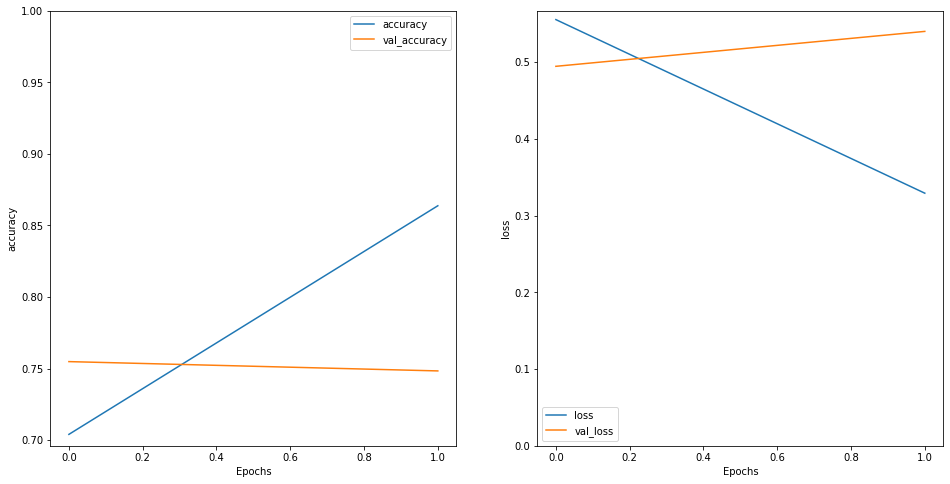

In [ ]:
my_polot_graphs(history_bidirectional)

### GRU (из лекции)

In [ ]:
model_gru, history_gru = my_rnn(GRU(64, recurrent_dropout=0.2))

Epoch 1/10
319/319 [==============================] - 54s 164ms/step - loss: 0.6077 - accuracy: 0.6519 - val_loss: 0.4949 - val_accuracy: 0.7551
Epoch 2/10
45/45 [==============================] - 1s 11ms/step - loss: 0.6466 - accuracy: 0.7297


Test score:  0.647
Test accuracy:  0.730


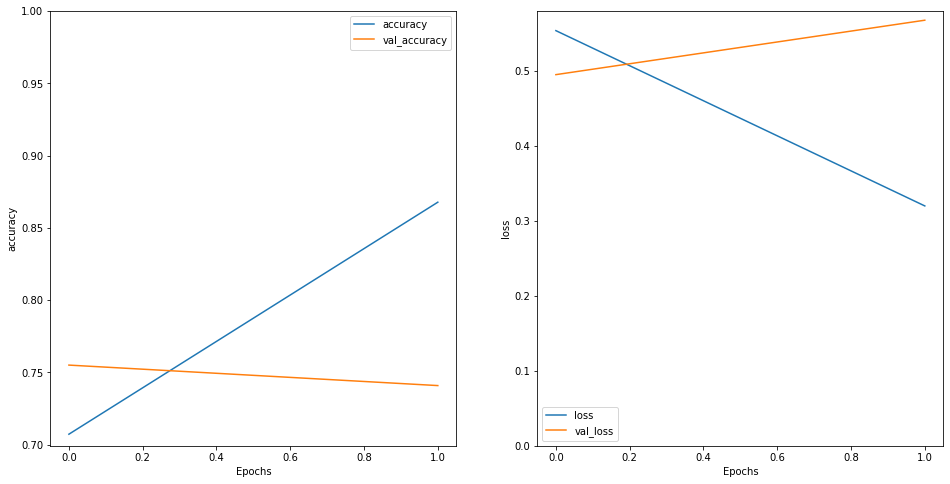

In [ ]:
my_plot_graphs(history_gru)

## CNN

In [ ]:
num_classes = 2
y_train_cnn = keras.utils.to_categorical(df_train["class"], num_classes)
y_val_cnn = keras.utils.to_categorical(df_val["class"], num_classes)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=word_count, output_dim=128, input_length=training_length))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train_cnn,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/10
319/319 [==============================] - 97s 304ms/step - loss: 0.5909 - accuracy: 0.6686 - val_loss: 0.4833 - val_accuracy: 0.7595
Epoch 2/10
319/319 [==============================] - 95s 297ms/step - loss: 0.2527 - accuracy: 0.9003 - val_loss: 0.5566 - val_accuracy: 0.7441


In [ ]:
score = model.evaluate(X_valid, y_val_cnn, batch_size=512, verbose=1)
print('\n')
print(f'Test score: { score[0]: .3f}' )
print(f'Test accuracy: {score[1]: .3f}')

45/45 [==============================] - 0s 5ms/step - loss: 0.6169 - accuracy: 0.7343


Test score:  0.617
Test accuracy:  0.734


In [ ]:
cnn_model, history_cnn = model, history

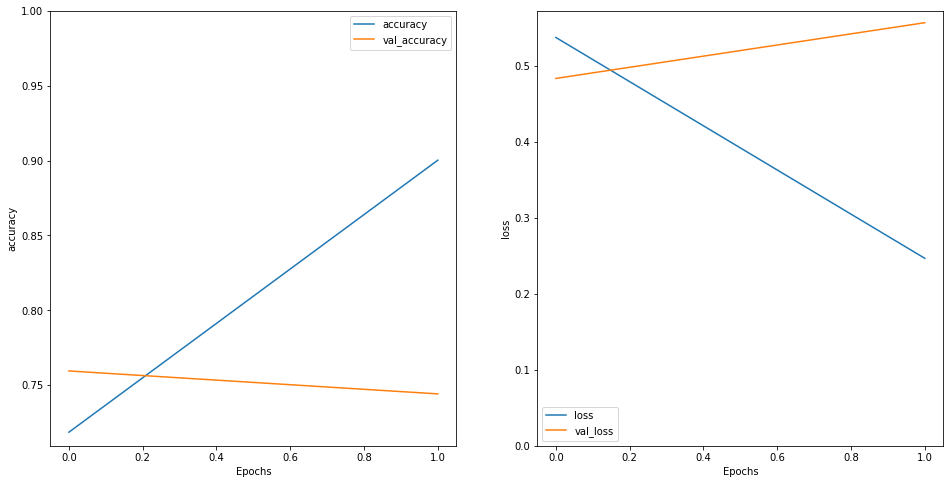

In [ ]:
my_plot_graphs(history_cnn)

## CNN показывает лучший результат, чем RNN, кроме двунаправленного

## Cовместно CNN и RNN

In [ ]:
model = Sequential()
model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(Conv1D(128, 3))

model.add(Bidirectional(LSTM(64)))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping=EarlyStopping(monitor='val_loss')  

history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print(f'Test score: { score[0]: .3f}' )
print(f'Test accuracy: {score[1]: .3f}')

Epoch 1/10
319/319 [==============================] - 102s 308ms/step - loss: 0.5936 - accuracy: 0.6616 - val_loss: 0.4839 - val_accuracy: 0.7612
Epoch 2/10
45/45 [==============================] - 0s 6ms/step - loss: 0.6455 - accuracy: 0.7325


Test score:  0.645
Test accuracy:  0.732


In [ ]:
rcnn_model, history_rcnn = model, history

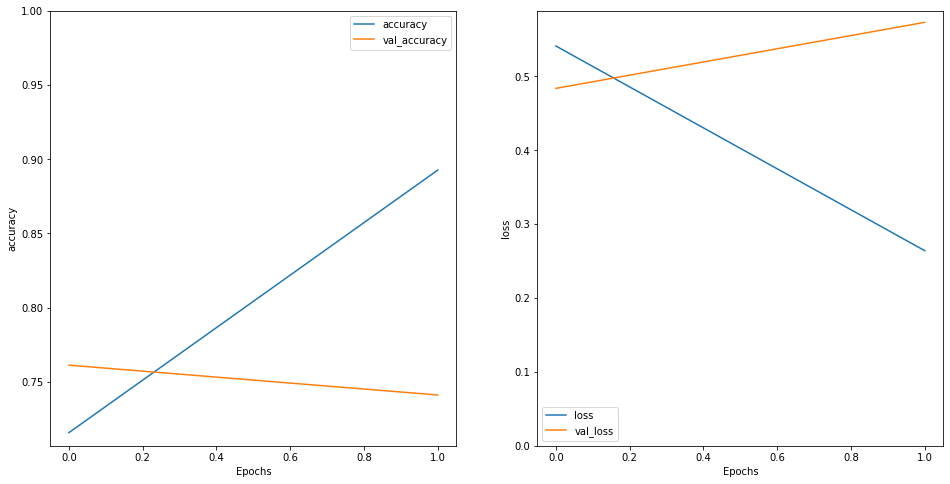

In [ ]:
my_plot_graphs(history_rcnn)

In [ ]:
model = Sequential()
model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(MaxPooling1D(2))

model.add(LSTM(64))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping=EarlyStopping(monitor='val_loss')  

history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print(f'Test score: { score[0]: .3f}' )
print(f'Test accuracy: {score[1]: .3f}')

Epoch 1/10
319/319 [==============================] - 97s 300ms/step - loss: 0.6243 - accuracy: 0.6364 - val_loss: 0.5238 - val_accuracy: 0.7311
Epoch 2/10
45/45 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.6988


Test score:  0.693
Test accuracy:  0.699


Не лучше раздельных моделей